In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
import os

# Tạo thư mục .kaggle nếu chưa có
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Copy file kaggle.json vào thư mục .kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download manjilkarki/deepfake-and-real-images
!unzip deepfake-and-real-images

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513

In [21]:
#!cd Dataset/Train/Fake && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
#!cd Dataset/Train/Real && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
#!cd Dataset/Validation/Fake && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
#!cd Dataset/Validation/Real && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
#!cd Dataset/Test/Fake && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
#!cd Dataset/Test/Real && ls | shuf -n $(($(ls | wc -l) / 3)) | xargs rm
!ls /content/Dataset/Train/Real | wc -l
!ls /content/Dataset/Train/Fake | wc -l
!ls /content/Dataset/Validation/Real | wc -l
!ls /content/Dataset/Validation/Fake | wc -l
!ls /content/Dataset/Test/Real | wc -l
!ls /content/Dataset/Test/Fake | wc -l

2732
2732
3910
3880
3609
3662


In [23]:
# Import thư viện
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [24]:
# Đường dẫn đến thư mục
train_dir = '/content/Dataset/Train'  # Real và Fake là dữ liệu train
val_dir = '/content/Dataset/Validation'  # Valuation là dữ liệu validation

# Kích thước ảnh
img_size = (128, 128)

# Data augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu train (Real và Fake)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=4,
    class_mode='binary',
    classes=['Real', 'Fake'],  # Gán nhãn: Real=0, Fake=1
    subset='training'
)

# Load dữ liệu validation
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=4,
    class_mode='binary',
    classes=['Real', 'Fake']   # Gán nhãn: Real=0, Fake=1
)

# Kiểm tra nhãn
print("Class indices:", train_generator.class_indices)

Found 5464 images belonging to 2 classes.
Found 7790 images belonging to 2 classes.
Class indices: {'Real': 0, 'Fake': 1}


In [25]:
# Load Xception base model (không bao gồm top layers)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Mở khóa 10 layer cuối của base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Thêm các layer tùy chỉnh
x = base_model.output
x = GlobalAveragePooling2D()(x)          # Giảm chiều dữ liệu
x = Dense(512, activation='relu')(x)     # Fully connected layer
x = Dropout(0.5)(x)                      # Dropout để tránh overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output layer cho binary classification


# Tạo model hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Compile lại với learning rate nhỏ
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Early stopping: dừng sau 5 epochs không cải thiện val_accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Model checkpoint: lưu model có val_accuracy cao nhất
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_deepfake_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

In [27]:
# Huấn luyện model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # Số epochs lớn, nhưng early stopping sẽ dừng sớm nếu cần
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5342 - loss: 0.6880 - precision: 0.5323 - recall: 0.4778

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 128s 60ms/step - accuracy: 0.5342 - loss: 0.6880 - precision: 0.5323 - recall: 0.4779 - val_accuracy: 0.7051 - val_loss: 0.8403 - val_precision: 0.6815 - val_recall: 0.7660
Epoch 2/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7033 - loss: 0.5756 - precision: 0.7140 - recall: 0.6767

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.7033 - loss: 0.5756 - precision: 0.7141 - recall: 0.6767 - val_accuracy: 0.7622 - val_loss: 0.7313 - val_precision: 0.7492 - val_recall: 0.7855
Epoch 3/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7583 - loss: 0.4962 - precision: 0.7758 - recall: 0.7353

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - accuracy: 0.7583 - loss: 0.4962 - precision: 0.7758 - recall: 0.7353 - val_accuracy: 0.7785 - val_loss: 0.8069 - val_precision: 0.7480 - val_recall: 0.8373
Epoch 4/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7821 - loss: 0.4587 - precision: 0.7864 - recall: 0.7762

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 145s 63ms/step - accuracy: 0.7821 - loss: 0.4587 - precision: 0.7864 - recall: 0.7762 - val_accuracy: 0.7976 - val_loss: 0.6924 - val_precision: 0.7677 - val_recall: 0.8513
Epoch 5/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7853 - loss: 0.4453 - precision: 0.7884 - recall: 0.7855

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 137s 60ms/step - accuracy: 0.7853 - loss: 0.4453 - precision: 0.7884 - recall: 0.7856 - val_accuracy: 0.8098 - val_loss: 0.5743 - val_precision: 0.7823 - val_recall: 0.8564
Epoch 6/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8054 - loss: 0.4073 - precision: 0.8111 - recall: 0.8014

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 88s 64ms/step - accuracy: 0.8055 - loss: 0.4073 - precision: 0.8111 - recall: 0.8014 - val_accuracy: 0.8320 - val_loss: 0.3939 - val_precision: 0.8085 - val_recall: 0.8685
Epoch 7/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 134s 59ms/step - accuracy: 0.8147 - loss: 0.4103 - precision: 0.8148 - recall: 0.8171 - val_accuracy: 0.8308 - val_loss: 0.4176 - val_precision: 0.8111 - val_recall: 0.8605
Epoch 8/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - accuracy: 0.8352 - loss: 0.3873 - precision: 0.8381 - recall: 0.8257 - val_accuracy: 0.8264 - val_loss: 0.5496 - val_precision: 0.7937 - val_recall: 0.8801
Epoch 9/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8381 - loss: 0.3668 - precision: 0.8333 - recall: 0.8425

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 83s 61ms/step - accuracy: 0.8381 - loss: 0.3668 - precision: 0.8333 - recall: 0.8425 - val_accuracy: 0.8480 - val_loss: 0.3401 - val_precision: 0.8314 - val_recall: 0.8716
Epoch 10/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.8412 - loss: 0.3554 - precision: 0.8459 - recall: 0.8262 - val_accuracy: 0.8463 - val_loss: 0.3405 - val_precision: 0.8296 - val_recall: 0.8700
Epoch 11/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8512 - loss: 0.3330 - precision: 0.8585 - recall: 0.8443

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 87s 63ms/step - accuracy: 0.8512 - loss: 0.3329 - precision: 0.8585 - recall: 0.8443 - val_accuracy: 0.8611 - val_loss: 0.3211 - val_precision: 0.8527 - val_recall: 0.8716
Epoch 12/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.8639 - loss: 0.3119 - precision: 0.8754 - recall: 0.8488 - val_accuracy: 0.8502 - val_loss: 0.3343 - val_precision: 0.8173 - val_recall: 0.9005
Epoch 13/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.8777 - loss: 0.3010 - precision: 0.8810 - recall: 0.8703 - val_accuracy: 0.8531 - val_loss: 0.3693 - val_precision: 0.8323 - val_recall: 0.8830
Epoch 14/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8832 - loss: 0.2852 - precision: 0.8840 - recall: 0.8824

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 88s 64ms/step - accuracy: 0.8832 - loss: 0.2852 - precision: 0.8840 - recall: 0.8824 - val_accuracy: 0.8810 - val_loss: 0.2859 - val_precision: 0.8926 - val_recall: 0.8652
Epoch 15/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.8862 - loss: 0.2710 - precision: 0.8964 - recall: 0.8736 - val_accuracy: 0.8807 - val_loss: 0.2891 - val_precision: 0.8879 - val_recall: 0.8703
Epoch 16/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.8844 - loss: 0.2561 - precision: 0.8923 - recall: 0.8741 - val_accuracy: 0.8776 - val_loss: 0.3211 - val_precision: 0.8935 - val_recall: 0.8564
Epoch 17/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9053 - loss: 0.2400 - precision: 0.9111 - recall: 0.8969 - val_accuracy: 0.8778 - val_loss: 0.3126 - val_precision: 0.9015 - val_recall: 0.8471
Epoch 18/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9097 - loss: 0.2283 - precision: 0.9187 - recall: 0.8982

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - accuracy: 0.9097 - loss: 0.2283 - precision: 0.9187 - recall: 0.8983 - val_accuracy: 0.8825 - val_loss: 0.2765 - val_precision: 0.8856 - val_recall: 0.8776
Epoch 19/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 133s 58ms/step - accuracy: 0.9213 - loss: 0.2066 - precision: 0.9264 - recall: 0.9168 - val_accuracy: 0.8776 - val_loss: 0.3416 - val_precision: 0.8989 - val_recall: 0.8500
Epoch 20/50
1365/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9281 - loss: 0.1818 - precision: 0.9347 - recall: 0.9171

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.9281 - loss: 0.1819 - precision: 0.9347 - recall: 0.9171 - val_accuracy: 0.8870 - val_loss: 0.2762 - val_precision: 0.9271 - val_recall: 0.8391
Epoch 21/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - accuracy: 0.9257 - loss: 0.1864 - precision: 0.9327 - recall: 0.9201 - val_accuracy: 0.8853 - val_loss: 0.2963 - val_precision: 0.9057 - val_recall: 0.8592
Epoch 22/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9241 - loss: 0.1871 - precision: 0.9307 - recall: 0.9149

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - accuracy: 0.9241 - loss: 0.1871 - precision: 0.9307 - recall: 0.9149 - val_accuracy: 0.8923 - val_loss: 0.3000 - val_precision: 0.9169 - val_recall: 0.8618
Epoch 23/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - accuracy: 0.9361 - loss: 0.1690 - precision: 0.9371 - recall: 0.9345 - val_accuracy: 0.8860 - val_loss: 0.5757 - val_precision: 0.9580 - val_recall: 0.8064
Epoch 24/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9372 - loss: 0.1601 - precision: 0.9491 - recall: 0.9238 - val_accuracy: 0.8919 - val_loss: 0.3968 - val_precision: 0.9098 - val_recall: 0.8690
Epoch 25/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9414 - loss: 0.1513 - precision: 0.9437 - recall: 0.9387

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - accuracy: 0.9414 - loss: 0.1513 - precision: 0.9437 - recall: 0.9387 - val_accuracy: 0.8960 - val_loss: 0.4088 - val_precision: 0.9465 - val_recall: 0.8387
Epoch 26/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9448 - loss: 0.1384 - precision: 0.9469 - recall: 0.9429 - val_accuracy: 0.8941 - val_loss: 0.3634 - val_precision: 0.9326 - val_recall: 0.8486
Epoch 27/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9450 - loss: 0.1461 - precision: 0.9528 - recall: 0.9377 - val_accuracy: 0.8943 - val_loss: 0.3508 - val_precision: 0.9177 - val_recall: 0.8654
Epoch 28/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9604 - loss: 0.1129 - precision: 0.9635 - recall: 0.9559

1366/1366 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.9604 - loss: 0.1129 - precision: 0.9635 - recall: 0.9559 - val_accuracy: 0.9007 - val_loss: 0.2687 - val_precision: 0.9415 - val_recall: 0.8539
Epoch 29/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 135s 58ms/step - accuracy: 0.9517 - loss: 0.1329 - precision: 0.9587 - recall: 0.9450 - val_accuracy: 0.8888 - val_loss: 0.4022 - val_precision: 0.9424 - val_recall: 0.8272
Epoch 30/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.9542 - loss: 0.1305 - precision: 0.9568 - recall: 0.9536 - val_accuracy: 0.8980 - val_loss: 0.3087 - val_precision: 0.9274 - val_recall: 0.8629
Epoch 31/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9514 - loss: 0.1189 - precision: 0.9560 - recall: 0.9453 - val_accuracy: 0.8941 - val_loss: 0.2915 - val_precision: 0.9510 - val_recall: 0.8301
Epoch 32/50
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.9551 - loss: 0.1169 - precision: 0.9584 - recall: 0.9502 - val_accuracy: 0.8996 

In [28]:
model.save('full_modeldf1.h5')

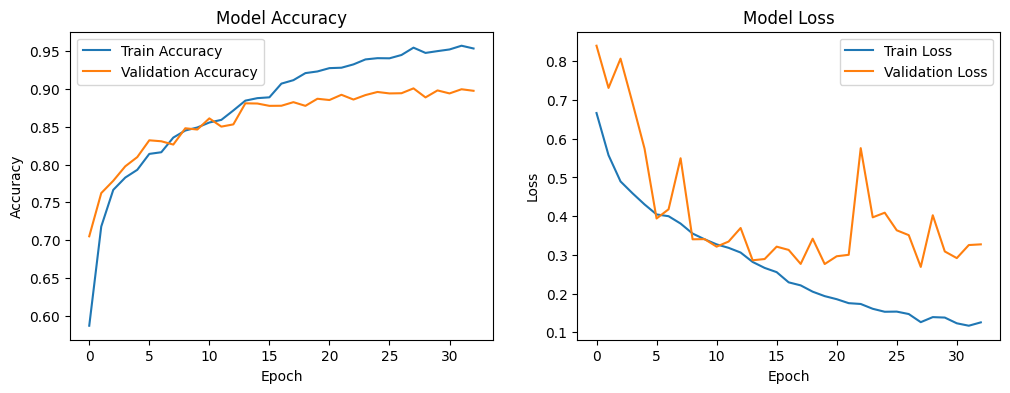

In [29]:
# Vẽ biểu đồ accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
# Load model tốt nhất
#best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_deepfake_model.h5')
best_model = tf.keras.models.load_model('/content/full_modeldf1.h5')
# Đánh giá trên tập validation
val_loss, val_accuracy, val_precision, val_recall = best_model.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')

1948/1948 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.8963 - loss: 0.2744 - precision: 0.9355 - recall: 0.8500
Validation Loss: 0.2686
Validation Accuracy: 0.9008
Validation Precision: 0.9415
Validation Recall: 0.8539


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


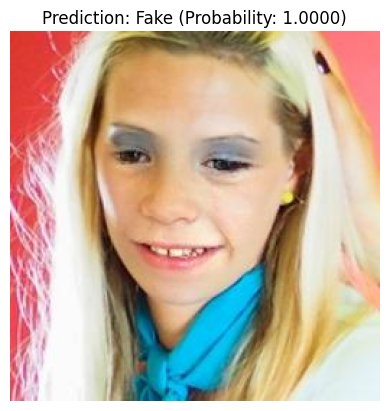

Image: /content/fake_1.jpg
Result: Fake
Probability of being Fake: 1.0000


In [35]:
# Import thư viện cần thiết
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình đã huấn luyện
model_path = '/content/drive/MyDrive/best_deepfake_model.h5'  # Đường dẫn đến mô hình tốt nhất
model = tf.keras.models.load_model(model_path)

# Hàm xử lý hình ảnh
def preprocess_image(image_path, target_size=(128, 128)):
    # Đọc hình ảnh bằng OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Không thể đọc hình ảnh từ đường dẫn: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB

    # Resize về 128x128
    img = cv2.resize(img, target_size)

    # Chuẩn hóa pixel về [0, 1]
    img = img / 255.0

    # Thêm batch dimension
    img = np.expand_dims(img, axis=0)

    return img

# Hàm dự đoán
def predict_deepfake(image_path):
    # Xử lý hình ảnh
    processed_img = preprocess_image(image_path)

    # Dự đoán với mô hình
    prediction = model.predict(processed_img)[0][0]  # Lấy giá trị đầu ra (0 đến 1)

    # Ngưỡng để phân loại (threshold = 0.5)
    if prediction < 0.5:
        result = "Real"
    else:
        result = "Fake"

    # Trả về kết quả và xác suất
    return result, prediction

# Đường dẫn đến hình ảnh (thay đổi đường dẫn này theo hình ảnh của bạn)
image_path = '/content/fake_1.jpg'  # Ví dụ: đường dẫn trên Google Drive

# Dự đoán và hiển thị kết quả
try:
    result, probability = predict_deepfake(image_path)

    # Hiển thị hình ảnh
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result} (Probability: {probability:.4f})")
    plt.show()

    # In kết quả
    print(f"Image: {image_path}")
    print(f"Result: {result}")
    print(f"Probability of being Fake: {probability:.4f}")

except ValueError as e:
    print(e)
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")